In [1]:
import os
import obspy
from obspy.core.stream import Stream
from obspy import read_inventory
from obspy.core import UTCDateTime
from obspy.clients.fdsn import Client
from obspy.clients.fdsn.header import URL_MAPPINGS
from obspy.geodetics import gps2dist_azimuth
from obspy import read
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import math
import cartopy.crs as ccrs
import numpy as np
from scipy import signal
from scipy.fft import fftshift
import sqlite3
from prelude import *

In [2]:
event_start = UTCDateTime(2019,2,12)
event_end = UTCDateTime(2019,2,17)

In [3]:
print(UTCDateTime(2019,2,13).timestamp)
print(UTCDateTime(2019,3,26).timestamp)

1550016000.0
1553558400.0


In [4]:

client = Client("IRIS")

cat = client.get_events(starttime=event_start,endtime=event_end,minmagnitude=3.0)
print(cat)

232 Event(s) in Catalog:
2019-02-16T23:22:23.770000Z | +54.839, +163.268 | 4.1  mb
2019-02-16T23:10:21.620000Z | -12.114,  -74.206 | 4.3  mb
...
2019-02-12T01:45:38.348000Z | +69.544, -144.867 | 3.2  ML
2019-02-12T01:32:27.980000Z | +14.462,  +85.733 | 4.9  mb
To see all events call 'print(CatalogObject.__str__(print_all=True))'


In [5]:
def plot_catalog(cat):
    ax = plt.axes(projection = ccrs.PlateCarree())
    print(ccrs.PlateCarree())
    ax.stock_img()
    ax.set_xlim(left=-167,right=-123)
    ax.set_ylim(bottom = 46, top = 73)
    lat = []
    lon = []
    for e in cat:
    #print(e)
    #print(e["origins"])
        for o in e["origins"]:
            lat.append(o.latitude)
            lon.append(o.longitude)
        
        #print("lat: {} lon: {}".format(o.latitude,o.longitude))
    plt.scatter(lon,lat,transform=ccrs.PlateCarree())
#plt.scatter([64.2],[-147.32],transform=ccrs.PlateCarree())
    plt.scatter([-147.32],[64.2],transform=ccrs.PlateCarree())
    plt.show()

4 Event(s) in Catalog:
2019-02-16T22:35:07.276000Z | +69.486, -144.073 | 4.0  ml
2019-02-15T22:57:31.709000Z | +66.302, -157.227 | 3.6  ml
2019-02-12T19:06:19.270000Z | +65.550, -166.815 | 3.8  ml
2019-02-12T11:11:34.932000Z | +61.273, -149.930 | 3.7  ML


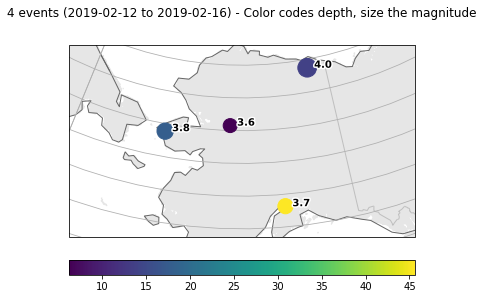

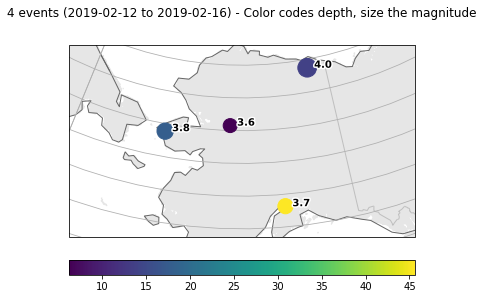

In [6]:
cat_new = cat.filter("longitude >= -167","longitude <= -123","latitude >= 54","magnitude >= 3.6")
print(cat_new)
cat_new.plot(projection="local")

In [7]:

stations= read_inventory("/scratch/naalexeev/NODAL/stations.xml")
def get_streams(event_time,event_lat,event_lon,buffer_time=60.0,max_dist = 130000.0):
    data_path = Path("/scratch/naalexeev/NODAL")


    selected_traces = []
    for file in data_path.iterdir():
        if not file.name in bad_files():

            stem_split = file.stem.split(".")
  
            start_time = UTCDateTime(stem_split[0]+"."+stem_split[1])
            end_time = UTCDateTime(stem_split[2]+"."+stem_split[3])
            read_start = event_time-buffer_time
            read_end = event_time+buffer_time
           
            if start_time<event_time and end_time>event_time:
                read_path = data_path/file
                #print(read_path)
                stream = read(str(read_path),starttime = read_start,endtime = read_end)
                for tr in stream:
                    #rint(tr.stats)
                    seed_id = "{}.{}..{}".format(tr.stats["network"],
                                                 tr.stats["station"],
                                                 tr.stats["channel"])
                    coords = stations.get_coordinates(seed_id)
                    #rint(coords)
                    st_lat = coords["latitude"]
                    st_lon = coords["longitude"]
                    distance =gps2dist_azimuth(st_lat,st_lon,event_lat,event_lon)[0]
                    # todo: change distance to something real
                    if distance<=max_dist:
                        
                        tr.stats.distance = distance
                        selected_traces.append(tr)
                    
                    
    stream = Stream(selected_traces)
    
    return stream
    
    

In [8]:
streams = []
for e in cat_new:
    for o in e.origins:
        print("({},{}): {}".format(o.latitude,o.longitude,o.time))
        
        stream = get_streams(o.time,o.latitude,o.longitude)
        streams.append((stream,e,{"lat":o.latitude,"lon":o.longitude,"time":o.time}))
        

(69.4858,-144.0733): 2019-02-16T22:35:07.276000Z
(66.3022,-157.2273): 2019-02-15T22:57:31.709000Z
(65.5499,-166.8147): 2019-02-12T19:06:19.270000Z
(61.2728,-149.9304): 2019-02-12T11:11:34.932000Z


In [9]:
for s in streams:
    print(len(s[0]))

0
0
0
39


In [11]:
streams[0][3].plot()

IndexError: tuple index out of range

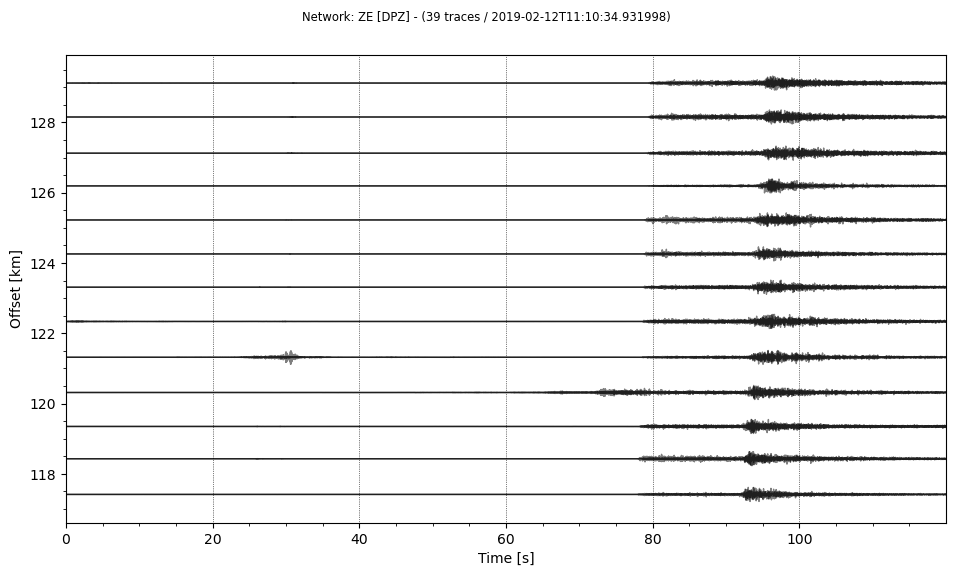

In [12]:
streams[3][0].plot(type="section",ev_coords = (100,100),orientation = "horizontal",outfile="out.png")

/home/naalexeev/.conda/envs/conda_env/lib/python3.10/site-packages/obspy/imaging/spectrogram.py:147: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

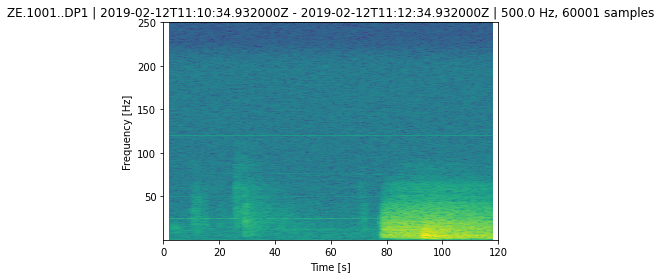

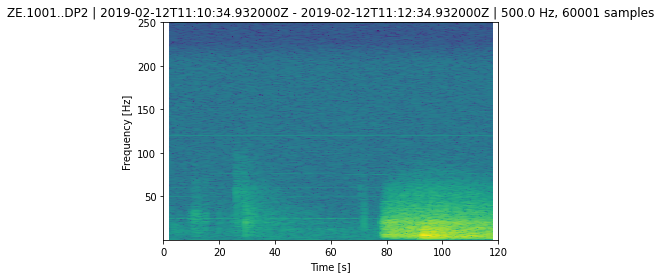

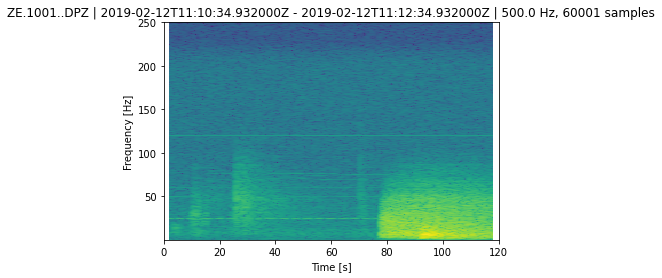

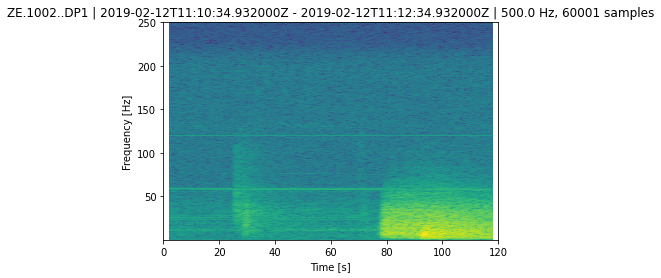

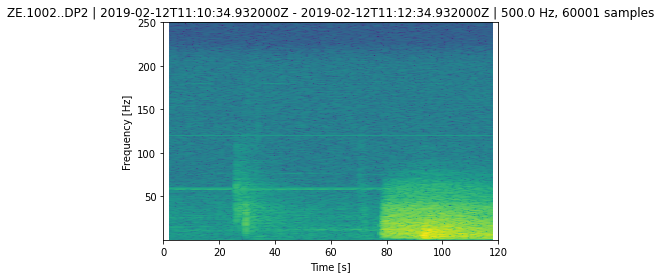

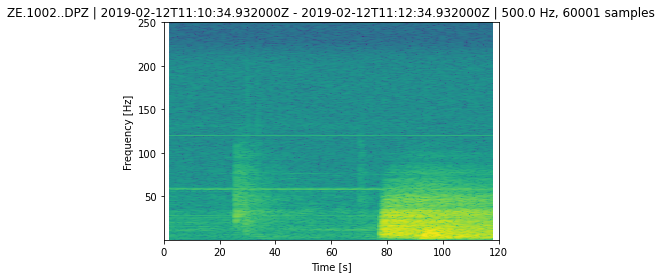

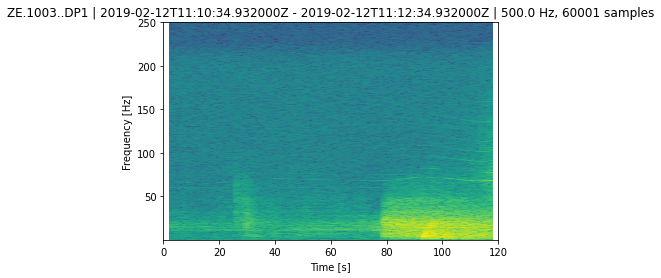

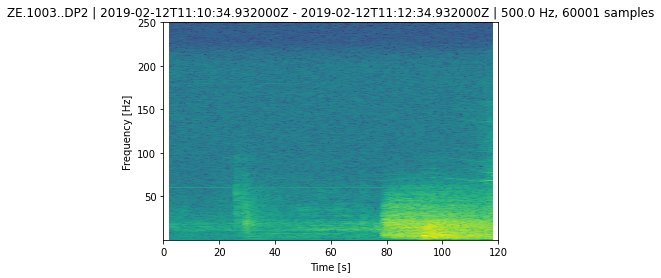

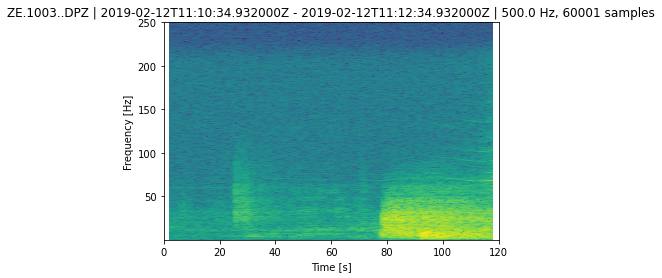

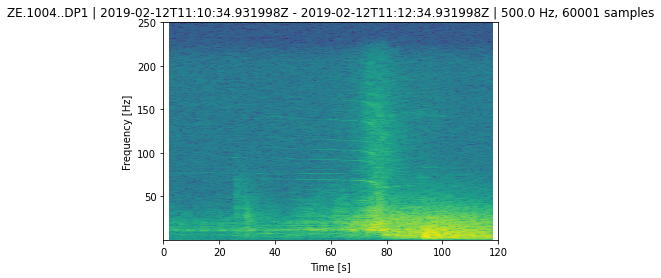

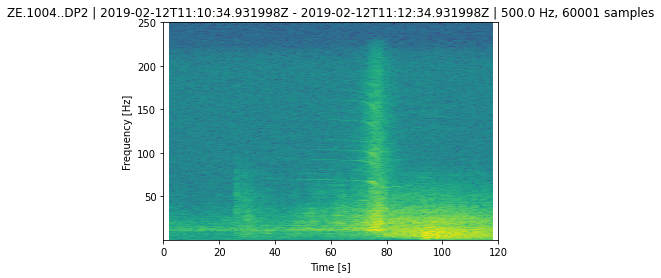

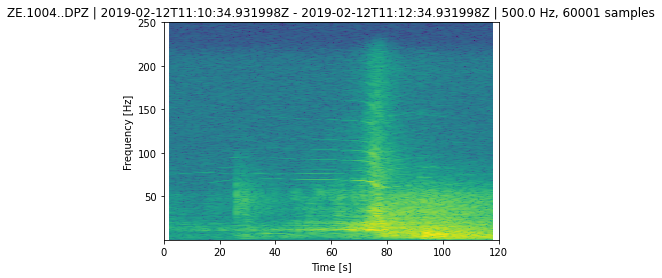

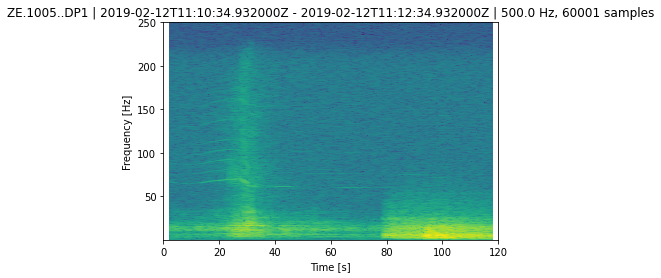

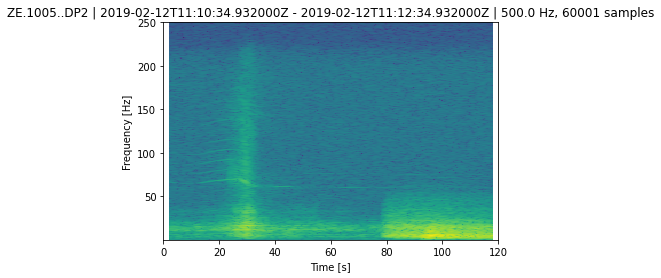

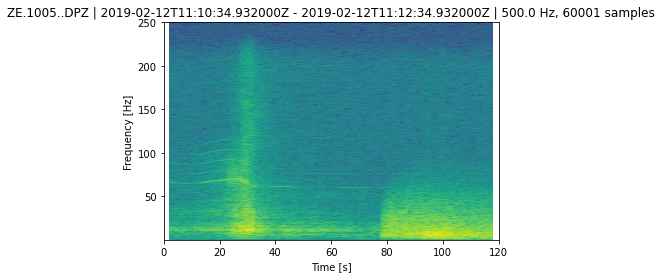

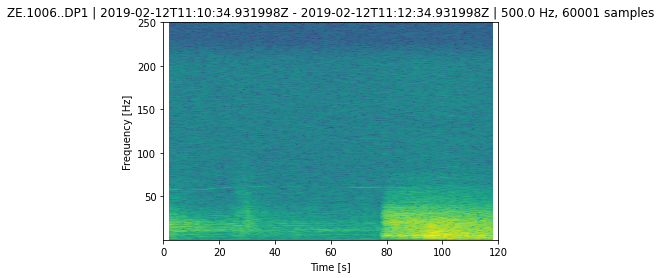

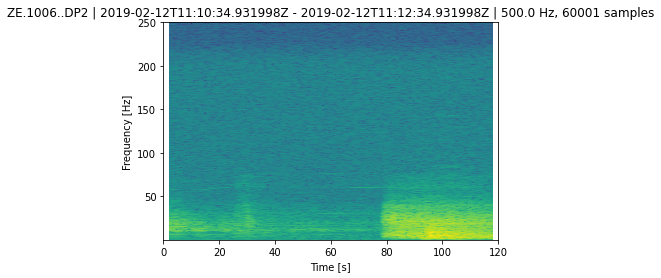

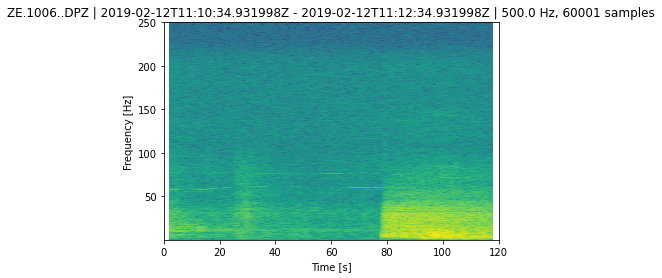

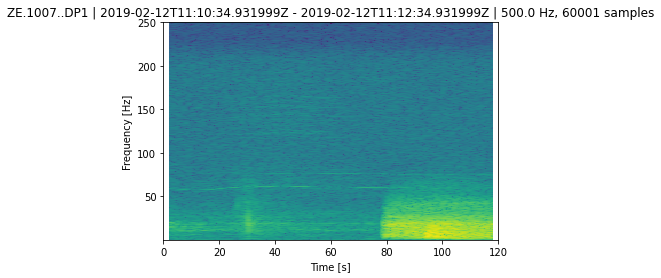

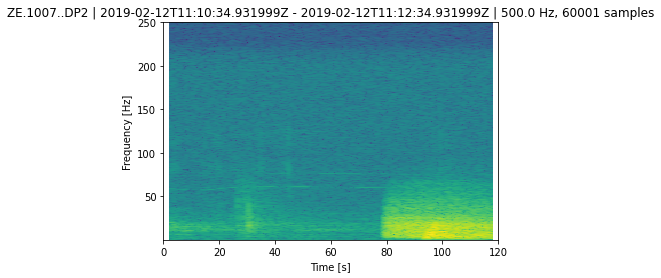

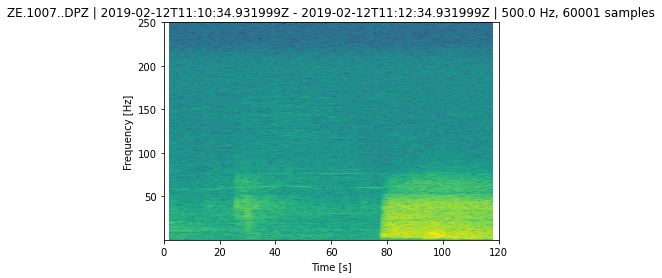

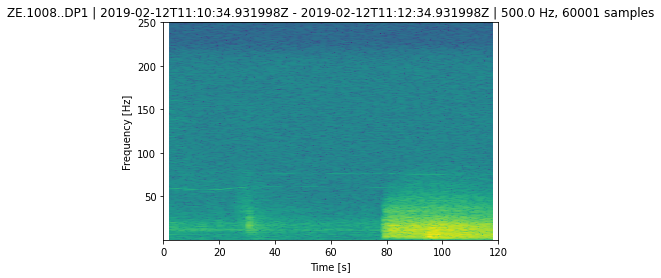

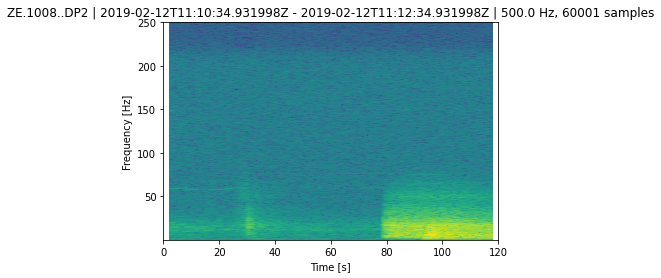

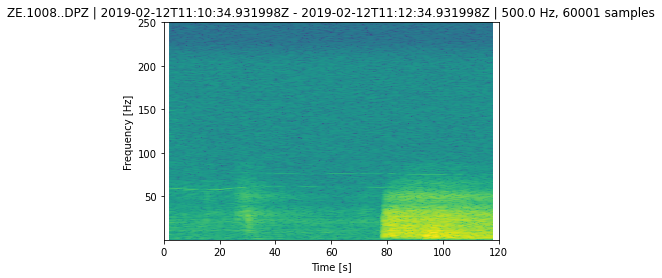

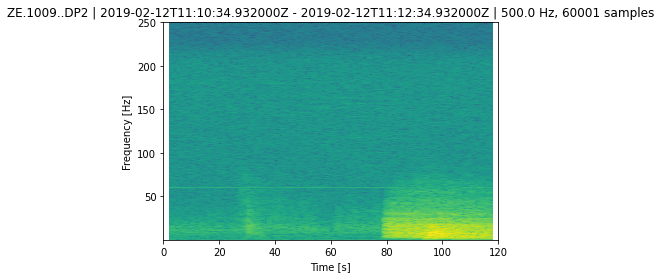

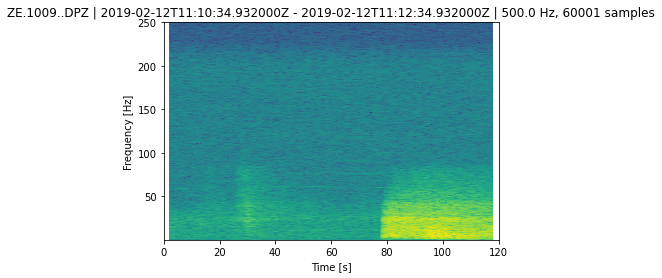

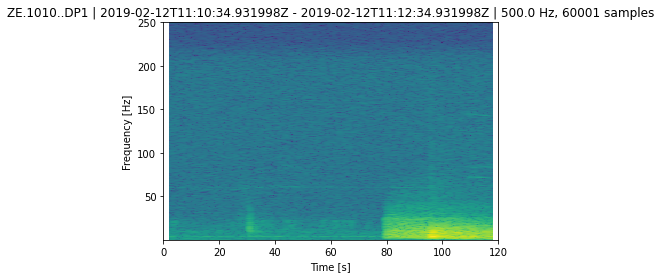

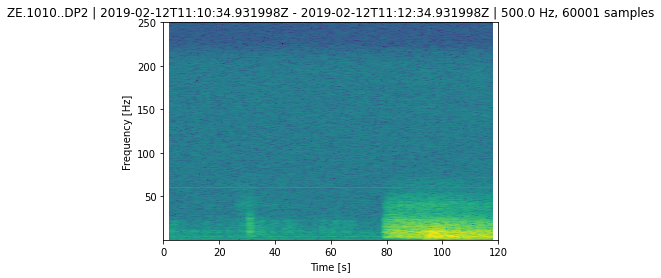

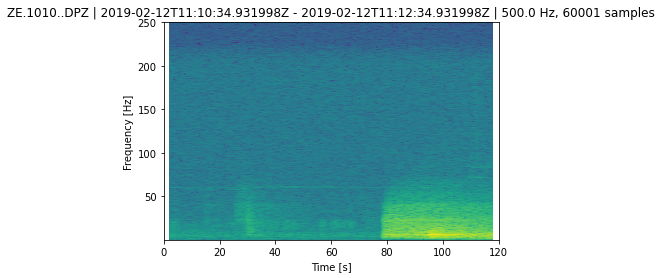

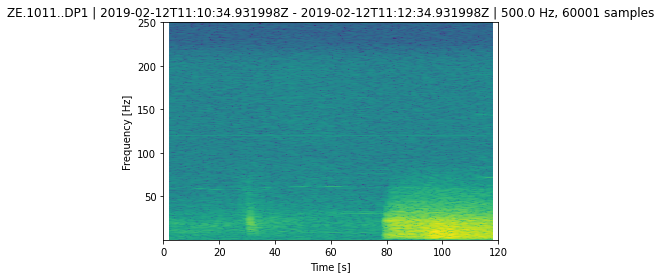

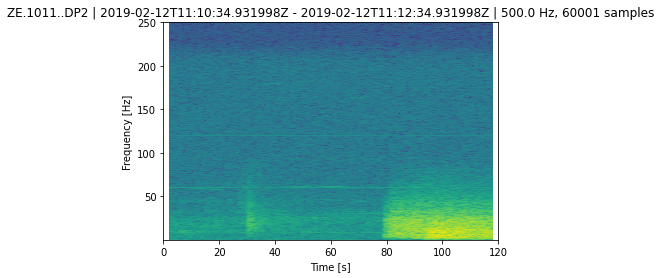

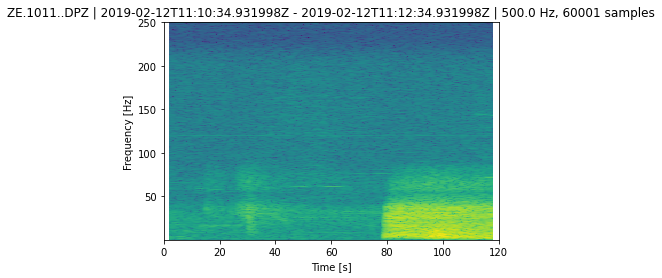

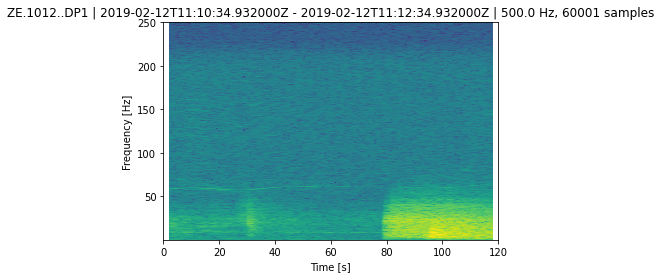

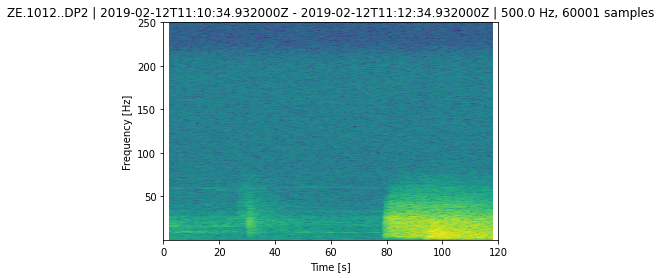

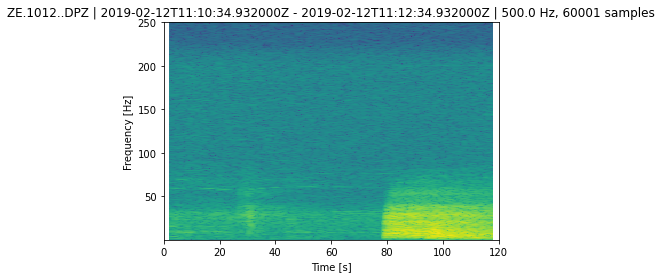

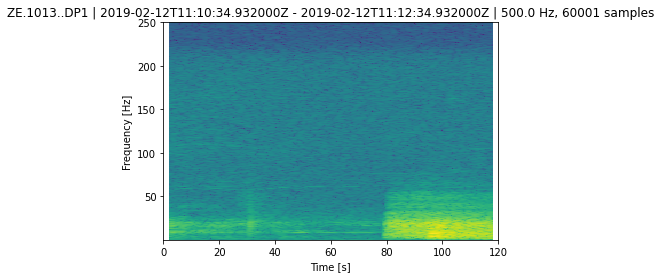

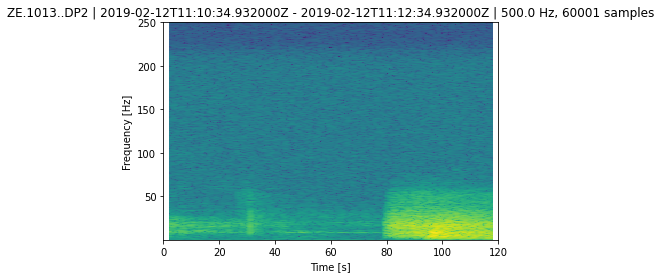

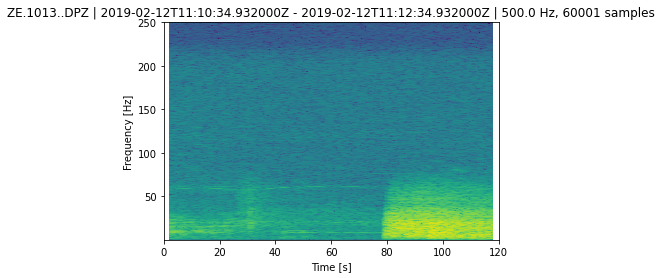

In [13]:
streams[3][0].spectrogram(outfile="spec.png",dbscale=True)

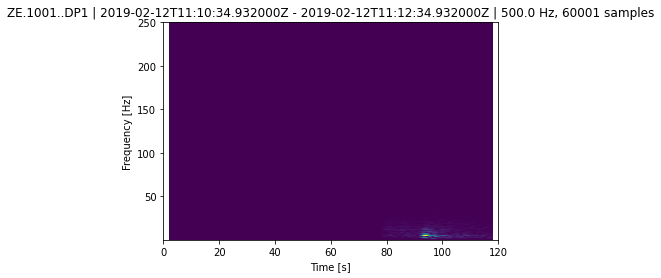

ZE.1001..DP1 | 2019-02-12T11:10:34.932000Z - 2019-02-12T11:12:34.932000Z | 500.0 Hz, 60001 samples


In [14]:
test_tr = streams[3][0][0]
test_tr.spectrogram()
print(test_tr)

In [15]:
numpy_data = test_tr.data
print(numpy_data)

[ -210  -213  -211 ... -2855 -2185 -1607]


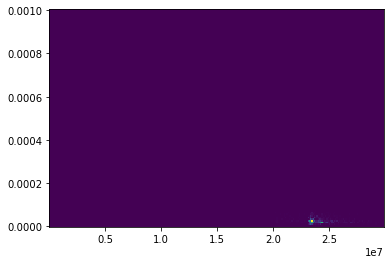

In [16]:
f,t,sxx = signal.spectrogram(numpy_data,fs = 1.0/500.0)
plt.pcolormesh(t,f,sxx)
plt.show()

4.0
39


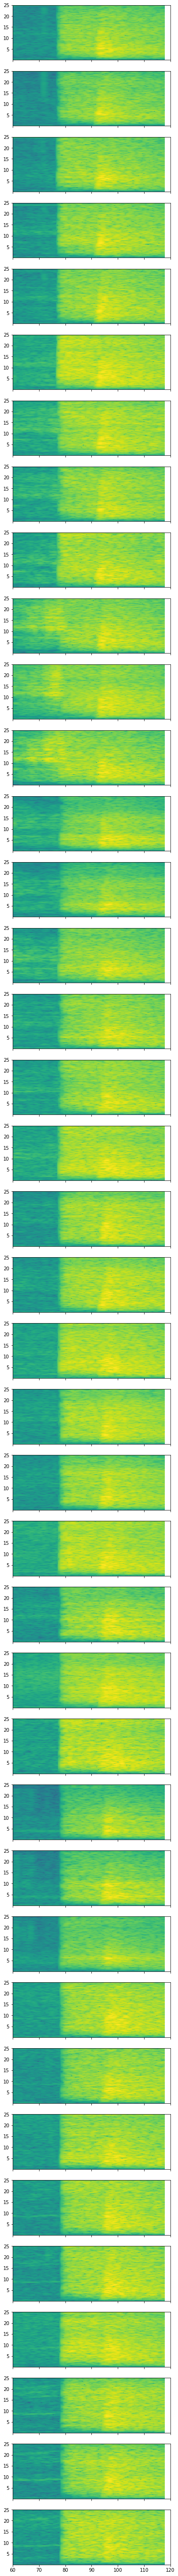

In [17]:
fig, ax = plt.subplots(len(streams[3][0]),1,sharex=True)
print(fig.get_figheight())
fig.set_figheight(100.0)
print(len(streams[3][0]))
i=0

for trace in streams[3][0]:
    a = trace.spectrogram(axes = ax[i],clip = [0.15,1.0],dbscale=True)
    a.set_ylim(top = 25.0)
    a.set_xlim(left=60.0)
    #a.set_ylabel("Frequency (Hz)")
    #a.set_xlabel("Time (s)")
    

    i+=1
plt.show()

4.0
39


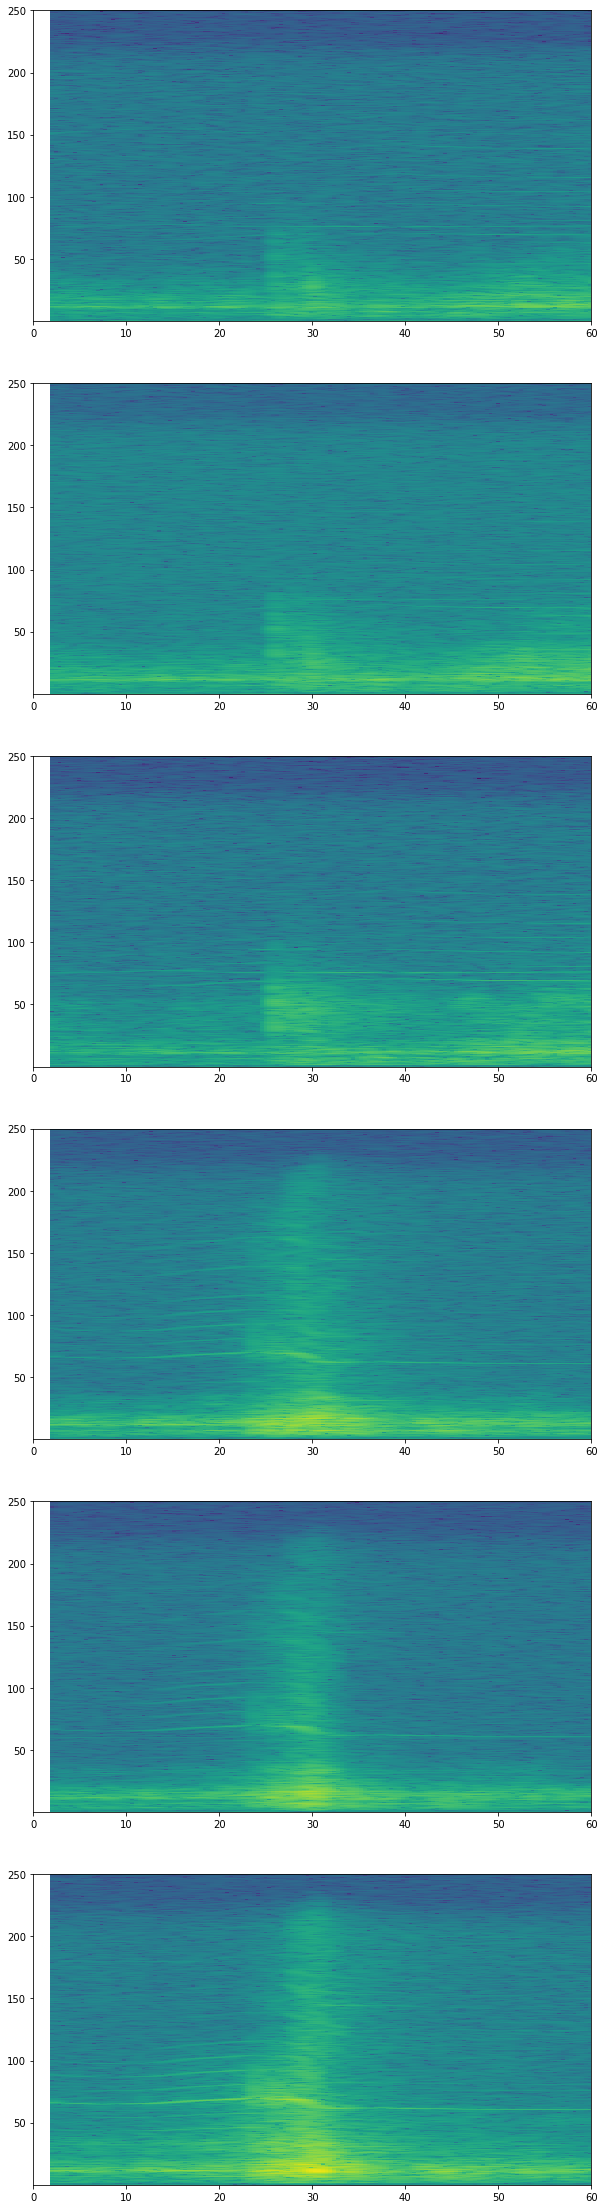

In [18]:
min_fig = 9
max_fig=15
fig, ax = plt.subplots(max_fig-min_fig,1,sharex=False)


print(fig.get_figheight())
fig.set_figheight(40.0)
fig.set_figwidth(10.0)
print(len(streams[3][0]))
h_lines = []
for i in range(0,25):
    h_lines.append(float(i)*10.0)
v_lines = []
for i in range(0,60):
    v_lines.append(float(i))
i=0

for trace in streams[3][0][min_fig:max_fig]:
    a = trace.spectrogram(axes = ax[i],clip = [0.15,1.0],dbscale=True)
    
    #a.set_ylim(top = 25.0)
    a.set_xlim(right=60.0)
    #a.hlines(h_lines,0,60.0,colors=["r"],linestyles="dotted")
    #a.vlines(v_lines,0,250.0,colors=["r"],linestyles="dotted")
    #a.set_ylabel("Frequency (Hz)")
    #a.set_xlabel("Time (s)")
    

    i+=1
plt.show()

10.333333333333334


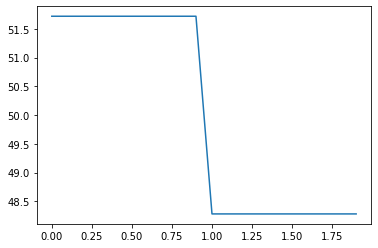

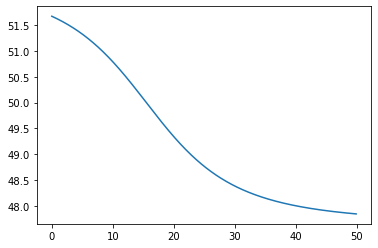

In [19]:

def doplar(car_pos,car_vel,station_pos,sound_speed,f_0):
    vel = np.dot((station_pos-car_pos),car_vel)/np.linalg.norm(station_pos-car_pos)
    return vel*f_0/sound_speed+f_0
   
print(doplar(np.array([0.0,0.0,0.0]),np.array([10.0,0.0,0.0]),np.array([10.0,0.0,0.0]),300.0,10.0))
def plot_doplar(car_pos,car_vel,station_pos,end_time,sound_speed,f_0):
    time_step = 0.1
    y = []
    x=[]
    distance = []
    for i in range(0,int(math.ceil(end_time/time_step))):
        new_pos = car_pos+i*time_step*car_vel
       # print("new_pos: {}".format(new_pos))
        doplar_res = doplar(new_pos,car_vel,station_pos,sound_speed,f_0)
        #print("doplar_res: {}".format(doplar_res))
        y.append(doplar_res)
        x.append(i*time_step)
        distance.append(np.linalg.norm(station_pos-new_pos))
    plt.plot(x,y)
    plt.show()
plot_doplar(
    np.array([0.0,0.0,0.0]),
    np.array([10.3,0.0,0.0]),
    np.array([10.0,0.0,0.0]),
    2.0,300.0,50.0)
plot_doplar(
    np.array([-300.0,0.0,0.0]),
    np.array([10.0,10.0,0.0]),
    np.array([10.0,0.0,0.0]),
    50.0,300.0,50.0)

In [ ]:
np.dot(np.array([1,0,0]),np.array([0,1,0]))

# Plotting planes data

In [ ]:
conn = sqlite3.connect("/scratch/naalexeev/flight_database.sqlite")

In [ ]:
planes = conn.execute("SELECT time,icao24,lat,lon from planes WHERE icao24=\"a34291\" LIMIT 100;").fetchall()


In [ ]:
def plot_planes(planes):
    ax = plt.axes(projection = ccrs.PlateCarree())
    print(ccrs.PlateCarree())
    ax.stock_img()
    ax.set_xlim(left=-167,right=-123)
    ax.set_ylim(bottom = 46, top = 73)
    lat = []
    lon = []
    for e in planes:

        lat.append(e[2])
        lon.append(e[3])
        
        #print("lat: {} lon: {}".format(o.latitude,o.longitude))
    plt.scatter(lon,lat,transform=ccrs.PlateCarree(),marker=",")
    plt.title(e[1])

 
    plt.show()
plot_planes(planes)

In [ ]:
ids = conn.execute("SELECT DISTINCT icao24 from planes LIMIT 100;").fetchall()
for pid in ids:
    print(pid)

# Get Most active planes

In [ ]:
active_planes = conn.execute("SELECT icao24, COUNT(icao24) as ic_count FROM planes GROUP BY icao24 ORDER BY ic_count DESC LIMIT 30").fetchall()
for i in active_planes:
    print(i)

# Getting most active plane info

In [ ]:

pop_plane = conn.execute("SELECT time,icao24,lat,lon from planes WHERE icao24=\"ace149\" LIMIT 100000;").fetchall()
plot_planes(pop_plane)

# Gettimg lat lon bounding box

In [ ]:
min_max = conn.execute("SELECT MAX(lat) as max_lat,MIN(lat) as min_lat,MAX(lon) as max_lon,MIN(LON) as min_lon from planes;").fetchall()
print(min_max)

In [ ]:
def plot_plane(plane,limit=10000):
    p = conn.execute("SELECT time,icao24,lat,lon from planes WHERE icao24=\"{}\" LIMIT {};".format(plane,limit)).fetchall()
    plot_planes(p)
plot_plane("780232",limit=10000000)
for p in active_planes:
    plot_plane(p[0],limit=10000000)

can get rough size of aircraft based on table:
https://en.wikipedia.org/wiki/International_Civil_Aviation_Organization
all A's are probabbly bush planes
 bombardiar dash 8's are probabbly b or a C, 737's are a C

In [ ]:
p = conn.execute("SELECT time,icao24,lat,lon from planes WHERE icao24=\"{}\";".format("a7e151")).fetchall()

In [ ]:
print(p[0])
print(len(p))

In [ ]:
print(UTCDateTime(p[0][0]))

# Looking through data to find gaps

In [ ]:
def parse_download_str(s):
    bad_files = {"log.txt","sql_query.sql","stations.xml"}
    if s in bad_files:
        return None
    try:
        parts = s.split(".")
        if parts[0][0:4]=="2019":
            start_time = UTCDateTime(parts[0]+"."+parts[1])
            end_time = UTCDateTime(parts[2]+"."+parts[3])
            station_id = parts[4]
            return {"start_time":start_time,"end_time":end_time,"station_id":station_id}
        else:
            return None
    except e:
        print(s)
        print(e)
        return None
parse_download_str("2019-03-07T06:00:00.000000Z.2019-03-07T07:00:00.000000Z.1236.mseed")
parse_download_str("log.txt")

In [ ]:
conn.execute("DELETE from waveforms;")
print(conn.execute("select * from waveforms;").fetchall())
def parse_download_path(p):
    return parse_download_str(p.name)
i=0
for f in Path("/scratch/naalexeev/NODAL").iterdir():

    parsed = parse_download_path(f)

    if parsed is not None:

        conn.execute("INSERT into waveforms (station_id, start_time, end_time, path) VALUES (\"{}\", {}, {}, \"{}\");".format(
            parsed["station_id"],
            parsed["start_time"].timestamp,
            parsed["end_time"].timestamp,
            str(f)))
conn.commit()

In [ ]:
print(conn.execute("select * from waveforms LIMIT 40;").fetchall())

In [ ]:
print(conn.execute("select COUNT(station_id) from waveforms;").fetchall())

In [ ]:
start_time = UTCDateTime(conn.execute("select start_time from waveforms ORDER BY start_time ASC LIMIT 1;").fetchall()[0][0])
end_time = UTCDateTime(conn.execute("select end_time from waveforms ORDER BY end_time DESC LIMIT 1;").fetchall()[0][0])
print(start_time)
print(end_time)

In [ ]:
conn.execute("CREATE TABLE stations(station_id String)")

In [ ]:

def check_stations(start_time,end_time):
    inv = obspy.read_inventory("/scratch/naalexeev/NODAL/stations.xml")
    stations = set()
    for net in inv:
        for s in net:
  
            stations.add(s.code)
    # getting start time to be in middle of hour
    current_time = start_time
    i=0
    while current_time <=end_time:
    
            
        select_time = (current_time+20.0).timestamp

            
        exec_str = "SELECT DISTINCT station_id FROM waveforms WHERE start_time <= {} AND end_time >= {} AND path IS NOT NULL;".format(
                select_time,select_time)
     
        data = conn.execute(exec_str
                ).fetchall()
        found_stations = set()
        for row in data:
            found_stations.add(row[0])
            
            #if len(data)!=0:
        not_found_station = stations.difference(found_stations)
 
       

        for station in not_found_station:
            exec_str = "INSERT INTO waveforms (station_id,start_time, end_time, path) VALUES ('{}',{},{},NULL);".format(
                station,
                current_time.timestamp,
                current_time.timestamp+60.0*60.0)
            conn.execute(exec_str)
         
        current_time = current_time + 60.0*60.0
        conn.commit()
        
check_stations(start_time,end_time)
    

In [ ]:
gaps = conn.execute("SELECT station_id,start_time from waveforms where path IS NULL ORDER BY station_id,start_time ASC LIMIT 400;").fetchall()
for (station,start_time) in gaps:
    print("{}: {}".format(station,UTCDateTime(start_time)))

# Getting number of gaps

In [ ]:
print(conn.execute("SELECT COUNT(station_id) from waveforms where path IS NULL;").fetchall())